#### Background
This notebook seeks to quantify the value of leaving a certain number of tiles in the bag during the pre-endgame based on a repository of games. We will then implement these values as a pre-endgame heuristic in the Macondo speedy player to improve simulation quality.

Initial questions:
1. What is the probability that you will go out first if you make a play leaving N tiles in the bag?
2. What is the expected difference between your end-of-turn spread and end-of-game spread?
2. What's your win probability?

#### Implementation details
Similar

#### Assumptions
* We're only analyzing complete games

#### Next steps
* Standardize sign convention for spread.
* Start figuring out how to calculate pre-endgame spread

#### Quackle values for reference
* 0,0.0
* 1,-8.0
* 2,0.0
* 3,-0.5
* 4,-2.0
* 5,-3.5
* 6,-2.0
* 7,2.0
* 8,10.0,
* 9,7.0,
* 10,4.0,
* 11,-1.0,
* 12,-2.0

#### Runtime
I was able to run this script on my local machine for ~20M rows in 2 minutes.

In [95]:
from copy import deepcopy
import csv
from datetime import date
import numpy as np
import pandas as pd
import seaborn as sns
import time

log_folder = '../logs/'
log_file = log_folder + 'log_20200515_preendgames.csv'

todays_date = date.today().strftime("%Y%m%d")

In [2]:
final_spread_dict = {}
out_first_dict = {}
win_dict = {}

Store the final spread of each game for comparison. The assumption here is that the last row logged is the final turn of the game, so for each game ID we overwrite the final move dictionary until there are no more rows from that game

In [3]:
t0 = time.time()

with open(log_file,'r') as f:
    moveReader = csv.reader(f)
    next(moveReader)
    
    for i,row in enumerate(moveReader):
        if (i+1)%1000000==0:
            print('Processed {} rows in {} seconds'.format(i+1, time.time()-t0))
            
        if i<10:
            print(row)
            
        if row[0]=='p1':
            final_spread_dict[row[1]] = int(row[6])-int(row[11])
        else:
            final_spread_dict[row[1]] = int(row[11])-int(row[6])
            
        out_first_dict[row[1]] = row[0]
        
        # This flag indicates whether p1 won or not, with 0.5 as the value if the game was tied.
        win_dict[row[1]] = (np.sign(final_spread_dict[row[1]])+1)/2

['p2', 'J3DH3KGZPuqMEDDcFXJauQ', '1', 'CEIIORT', '8H TORIC', '20', '20', '5', 'EI', '21.853', '86', '0']
['p1', 'J3DH3KGZPuqMEDDcFXJauQ', '2', 'CDEIIJW', '9G JEW', '36', '36', '3', 'CDII', '33.265', '81', '20']
['p2', 'J3DH3KGZPuqMEDDcFXJauQ', '3', 'EFIMOQT', '10F MOTE', '30', '50', '4', 'FIQ', '21.483', '78', '36']
['p1', 'J3DH3KGZPuqMEDDcFXJauQ', '4', 'ACDHIII', 'L7 A.IDIC', '22', '58', '5', 'HI', '22.994', '74', '50']
['p2', 'J3DH3KGZPuqMEDDcFXJauQ', '5', 'BEFGIOQ', '11C BEFOG', '37', '87', '5', 'IQ', '32.050', '69', '58']
['p2', 'wvTRHqNYEEjCHJiuGDw3WM', '1', 'DEIOSTW', '8D WITED', '26', '26', '5', 'OS', '32.236', '86', '0']
['p1', 'J3DH3KGZPuqMEDDcFXJauQ', '6', 'AHIOORV', '12D HAO', '32', '90', '3', 'IORV', '29.935', '64', '87']
['p1', 'wvTRHqNYEEjCHJiuGDw3WM', '2', 'DENRTWZ', 'E7 W.ZEN', '34', '34', '4', 'DRT', '34.836', '81', '26']
['p2', 'J3DH3KGZPuqMEDDcFXJauQ', '7', 'AINQRTV', 'J10 TRANQ', '45', '132', '5', 'IV', '40.426', '61', '90']
['p2', 'wvTRHqNYEEjCHJiuGDw3WM', '3', 'AB

In [99]:
preendgame_boundaries = [8,21] # how many tiles are in the bag before we count as pre-endgame?
preendgame_tile_range = range(preendgame_boundaries[0],preendgame_boundaries[1]+1)
counter_dict = {x:{y:0 for y in range(x-7,x+1)} for x in preendgame_tile_range}

end_of_turn_spread_counter_dict = deepcopy(counter_dict)
equity_counter_dict = deepcopy(counter_dict)
final_spread_counter_dict = deepcopy(counter_dict)
game_counter_dict = deepcopy(counter_dict)
out_first_counter_dict = deepcopy(counter_dict)
win_counter_dict = deepcopy(counter_dict)

In [100]:
t0=time.time()
print('There are {} games'.format(len(final_spread_dict)))

with open(log_file,'r') as f:
    moveReader = csv.reader(f)
    next(moveReader)
    
    for i,row in enumerate(moveReader):
        if (i+1)%1000000==0:
            print('Processed {} rows in {} seconds'.format(i+1, time.time()-t0))
            
        beginning_of_turn_tiles_left = int(row[10])
        end_of_turn_tiles_left = int(row[10])-int(row[7])

        if (beginning_of_turn_tiles_left >= preendgame_boundaries[0] and 
                beginning_of_turn_tiles_left <= preendgame_boundaries[1]):

            end_of_turn_spread_counter_dict[beginning_of_turn_tiles_left][end_of_turn_tiles_left] +=\
                    int(row[6])-int(row[11])
            equity_counter_dict[beginning_of_turn_tiles_left][end_of_turn_tiles_left] +=\
                    float(row[9])-float(row[5])
            game_counter_dict[beginning_of_turn_tiles_left][end_of_turn_tiles_left] += 1        
            out_first_counter_dict[beginning_of_turn_tiles_left][end_of_turn_tiles_left] += \
                    out_first_dict[row[1]] == row[0]
            
            if row[0]=='p1':
                final_spread_counter_dict[beginning_of_turn_tiles_left][end_of_turn_tiles_left] += final_spread_dict[row[1]]
                win_counter_dict[beginning_of_turn_tiles_left][end_of_turn_tiles_left] += win_dict[row[1]]
            else:
                final_spread_counter_dict[beginning_of_turn_tiles_left][end_of_turn_tiles_left] -= final_spread_dict[row[1]]
                win_counter_dict[beginning_of_turn_tiles_left][end_of_turn_tiles_left] += (1-win_dict[row[1]])
            
#             if i<1000:
#                 print(row)
#                 print(game_counter_dict[beginning_of_turn_tiles_left])
#                 print(end_of_turn_spread_counter_dict[beginning_of_turn_tiles_left])
#                 print(equity_counter_dict[beginning_of_turn_tiles_left])
#                 print(final_spread_counter_dict[beginning_of_turn_tiles_left])
#                 print(win_counter_dict[beginning_of_turn_tiles_left])
#                 print(out_first_counter_dict[beginning_of_turn_tiles_left])

There are 817267 games
Processed 1000000 rows in 6.12558913230896 seconds
Processed 2000000 rows in 12.304726123809814 seconds
Processed 3000000 rows in 18.478058099746704 seconds
Processed 4000000 rows in 24.83176016807556 seconds
Processed 5000000 rows in 31.04086995124817 seconds
Processed 6000000 rows in 37.23697209358215 seconds
Processed 7000000 rows in 43.351113080978394 seconds
Processed 8000000 rows in 49.507063150405884 seconds
Processed 9000000 rows in 55.65527105331421 seconds
Processed 10000000 rows in 61.771941900253296 seconds
Processed 11000000 rows in 67.92959690093994 seconds
Processed 12000000 rows in 74.09148907661438 seconds
Processed 13000000 rows in 80.45722389221191 seconds
Processed 14000000 rows in 86.66879415512085 seconds
Processed 15000000 rows in 93.00681400299072 seconds
Processed 16000000 rows in 100.01332807540894 seconds
Processed 17000000 rows in 106.07342219352722 seconds
Processed 18000000 rows in 113.9096109867096 seconds


In [101]:
count_df = pd.DataFrame(game_counter_dict)
end_of_turn_spread_df = pd.DataFrame(end_of_turn_spread_counter_dict)
equity_df = pd.DataFrame(equity_counter_dict)
final_spread_df = pd.DataFrame(final_spread_counter_dict)
out_first_df = pd.DataFrame(out_first_counter_dict)
win_df = pd.DataFrame(win_counter_dict)

In [103]:
spread_delta_df = final_spread_df-end_of_turn_spread_df
avg_spread_delta_df = spread_delta_df/count_df
avg_equity_df = equity_df/count_df
out_first_pct_df = out_first_df/count_df
win_pct_df = 100*win_df/count_df

In [105]:
tst_df = avg_spread_delta_df-avg_equity_df

In [112]:
win_pct_df

,8,9,10,11,12,13,14,15,16,17,18,19,20,21
1,64.067768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,49.622253,63.503817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,48.908158,49.366943,62.899606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,47.531844,47.741778,48.617671,62.206813,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,47.013423,47.577463,47.411298,47.033326,61.883614,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,46.840432,47.445826,47.131751,47.442674,47.739955,62.520402,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,45.720911,47.315220,48.119363,47.884848,47.624033,48.109386,62.198169,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,45.464386,47.177406,48.024161,47.678076,48.217909,47.611465,62.320161,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,46.751607,47.402903,47.822687,47.841502,47.720709,48.653199,62.157020,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,45.206767,47.537308,47.616822,48.026502,47.473346,48.390994,62.532530,NaN,NaN,NaN,NaN


In [111]:
np.mean(tst_df,axis=1)

1    -17.718745
2    -19.031246
3    -21.642336
4    -23.528985
5    -24.749881
6    -24.512278
7    -23.943564
8    -24.244330
9    -23.473755
10   -23.327516
11   -23.463103
12   -23.747946
13   -23.774393
14   -24.063086
15   -24.199648
16   -24.369475
17   -23.879588
18   -23.772236
19   -24.046960
20   -25.216830
21          NaN
dtype: float64

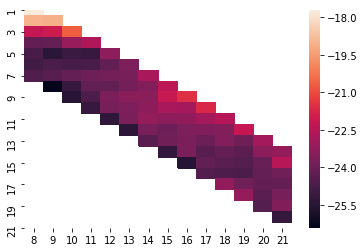

In [109]:
sns.heatmap(tst_df)

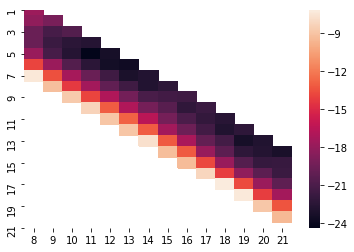

In [73]:
avg_spread_delta_plot = sns.heatmap(avg_spread_delta_df)
fig = avg_spread_delta_plot.get_figure()
fig.savefig("average_spread_delta.png")

In [59]:
quackle_peg_dict = {
    1:-8.0,
    2:0.0,
    3:-0.5,
    4:-2.0,
    5:-3.5,
    6:-2.0,
    7:2.0,
    8:10.0,
    9:7.0,
    10:4.0,
    11:-1.0,
    12:-2.0
}

quackle_peg_series = pd.Series(quackle_peg_dict, name='quackle_values')

In [60]:
df = pd.concat([df,quackle_peg_series],axis=1)

In [61]:
df['quackle_macondo_delta'] = df['quackle_values']-df['avg_spread_delta']

In [62]:
df = df.reset_index().rename({'index':'tiles_left_after_play'}, axis=1)

In [63]:
df

,tiles_left_after_play,end_of_turn_spread,final_spread,count,out_first_count,win_count,spread_delta,avg_spread_delta,out_first_pct,win_pct,quackle_values,quackle_macondo_delta
0,1,2584950,-138134,193090,139335,95801.5,-2723084,-14.102667,72.160650,49.614946,-8.0,6.102667
1,2,4869275,-167949,363028,228521,180795.5,-5037224,-13.875580,62.948588,49.802081,0.0,13.875580
2,3,7376835,208220,486274,263203,244043.0,-7168615,-14.741925,54.126480,50.186315,-0.5,14.241925
3,4,9202012,842544,588925,302620,298262.0,-8359468,-14.194453,51.385151,50.645159,-2.0,12.194453
4,5,7720501,-47604,617635,338494,309145.0,-7768105,-12.577177,54.804860,50.053025,-3.5,9.077177
5,6,5030287,-1226130,468590,260076,229800.5,-6256417,-13.351580,55.501825,49.040846,-2.0,11.351580
6,7,3688236,-412332,220456,61325,108957.5,-4100568,-18.600392,27.817342,49.423695,2.0,20.600392
7,8,3670547,931117,210489,83786,108728.5,-2739430,-13.014599,39.805406,51.655193,10.0,23.014599
8,9,3798585,812144,209899,107310,107768.5,-2986441,-14.227991,51.124588,51.343027,7.0,21.227991
9,10,3788064,358082,209460,120511,105784.0,-3429982,-16.375356,57.534135,50.503199,4.0,20.375356


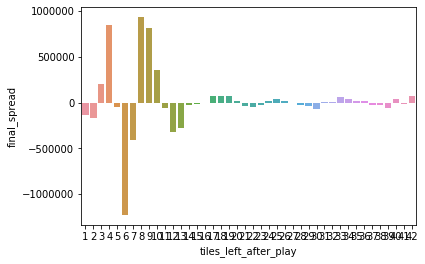

In [64]:
sns.barplot(x='tiles_left_after_play',y='final_spread',data=df)

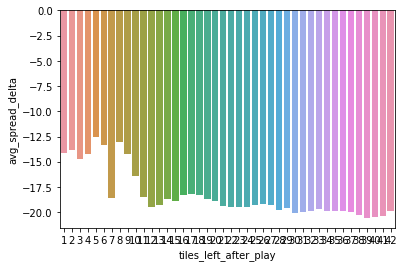

In [67]:
sns.barplot(x='tiles_left_after_play',y='avg_spread_delta',data=df)

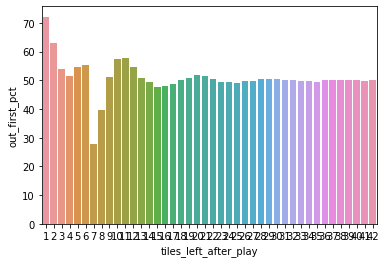

In [66]:
sns.barplot(x='tiles_left_after_play',y='out_first_pct',data=df)

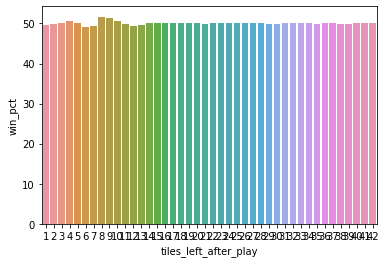

In [65]:
sns.barplot(x='tiles_left_after_play',y='win_pct',data=df)

Save a summary and a verbose version of preendgame heuristic values.

In [53]:
df['avg_spread_delta'].to_csv('peg_heuristics_' + todays_date + '.csv')
df.to_csv('peg_summary_' + todays_date + '.csv')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.
